In [24]:
#pip install google-generativeai
import sys
sys.setrecursionlimit(100000)
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
import pandas as pd
pd.set_option('display.max_colwidth', None)


In [25]:
import warnings
warnings.filterwarnings("ignore")


In [26]:
import os
from dotenv import load_dotenv
load_dotenv()

from groq import Groq
client = Groq(api_key=os.getenv("GROQ_API_KEY"))

class GroqLLM:
    def __init__(self, client, model):
        self.client = client
        self.model = model

    def __call__(self, query):
        response = self.client.chat.completions.create(
            model=self.model,
            messages=[{"role": "user", "content": str(query)}]
        )
        return response.choices[0].message.content

# Initialize like this
llm = GroqLLM(client, "llama-3.3-70b-versatile")


True

In [27]:
import os
from typing import List,TypedDict
from langgraph.graph import StateGraph,END
from langchain_community.vectorstores import FAISS
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_core.documents import Document

In [28]:
from langchain_community.embeddings import HuggingFaceBgeEmbeddings
emb = HuggingFaceBgeEmbeddings(model_name="thenlper/gte-small")

In [29]:
from langchain_community.document_loaders import RecursiveUrlLoader
from bs4 import BeautifulSoup as Soup

news_sites = [
    "https://www.bbc.com/news",
    "https://www.aljazeera.com/news/",
    "https://indianexpress.com/section/india/",
    "https://www.thehindu.com/news/",
    "https://www.reuters.com/world/"
]

all_docs = []

def extract_text(html):
    return Soup(html, "html.parser").get_text(separator="\n")

for url in news_sites:
    loader = RecursiveUrlLoader(
        url=url,
        max_depth=1,              # Keep shallow for news (faster, avoids old archives)
        extractor=extract_text
    )

    docs = loader.load()
    all_docs.extend(docs)

print(f"Loaded total documents: {len(all_docs)}")


Loaded total documents: 5


In [30]:
document = all_docs
print(document)


[Document(metadata={'source': 'https://www.bbc.com/news', 'content_type': 'text/html; charset=utf-8', 'title': 'BBC News - Breaking news, video and the latest top stories from the U.S. and around the world', 'description': 'Visit BBC News for the latest news, breaking news, video, audio and analysis. BBC News provides trusted World, U.S. and U.K. news as well as local and regional perspectives. Also entertainment, climate, business, science, technology and health news.', 'language': 'en-GB'}, page_content='BBC News - Breaking news, video and the latest top stories from the U.S. and around the world\nSkip to content\nBritish Broadcasting Corporation\nHome\nNews\nSport\nBusiness\nInnovation\nCulture\nArts\nTravel\nEarth\nAudio\nVideo\nLive\nIsrael-Gaza War\nWar in Ukraine\nUS & Canada\nUK\nAfrica\nAsia\nAustralia\nEurope\nLatin America\nMiddle East\nIn Pictures\nBBC InDepth\nBBC Verify\nHome\nNews\nIsrael-Gaza War\nWar in Ukraine\nUS & Canada\nUK\nUK Politics\nEngland\nN. Ireland\nN. Ire

In [31]:
from langchain_core.prompts import ChatPromptTemplate
prompt = ChatPromptTemplate.from_template("""
Answer the following question based on the provided context. 
Also if any code snippet is available please provide it.
Always answer for more then 100 words. 
<context>
{context}
</context>
Question : {input}""")

In [32]:
def format_docs(docs):
    return "\n\n".join(doc.page_content for doc in docs)


In [33]:
splitter = RecursiveCharacterTextSplitter(
    chunk_size=2000,
    chunk_overlap=500
)

docs = splitter.split_documents(document)

In [34]:
vectorstore = FAISS.from_documents(docs,embedding=emb)

In [35]:
retriever = vectorstore.as_retriever(k=3)


In [36]:
# context_docs = retriever.invoke("Give to me in detail about how to use agents in langchain")
# context = format_docs(context_docs)

# final_prompt = prompt.format(context=context, input="Give to me in detail about how to use agents in langchain")

# response = model.generate_content(final_prompt)
# print(response.text)


In [37]:
# print(context_docs)
retrieval = False

In [38]:
class AgentState(TypedDict):
    question: str
    documents: List[Document]
    answer:str
    needs_retrieval: bool

In [62]:
def decide_retrieval(state: AgentState) -> AgentState:
    question = state["question"]
    
    response = llm(
        f"""
        Return ONLY True or False.

        True → The question REQUIRES checking the news knowledge base because it asks about:
        - recent events
        - current affairs
        - politics, sports, economy, technology updates
        - breaking news or anything time-sensitive
        - information that changes daily and must come from scraped news articles

        False → The question is general knowledge OR does not depend on recent news.

        Do NOT answer based on whether the LLM knows the answer.
        Decide ONLY based on whether the latest news articles are required.

        Question: {question}
        """
        )
    
    cleaned = response.strip().lower()
    needs_retrieval = cleaned.startswith("t")
    
    return {**state, "needs_retrieval": needs_retrieval}

In [63]:
def retrieve_documents(state:AgentState) -> AgentState:
    question = state['question']

    documents = retriever.invoke(question)

    return {**state,"documents":documents}

In [64]:
def generate_answer(state:AgentState) -> AgentState:
    question = state['question']
    documents = state.get("documents",[])

    if documents:
        context = "\n\n".join([doc.page_content for doc in documents])
        prompt = f"""
                    Based on the following context, answer the question : 
                    Context : {context}
                    Question : {question}
                    Answer : 
                    """
    else:
        prompt = f"Answer the following question : {question}"
    response = llm(prompt)
    answer = response

    return {**state,"answer":answer}

In [65]:
def should_retrieve(state:AgentState) -> AgentState:
    if state["needs_retrieval"]:
        return "retrieve"
    else:
        return "generate"

In [66]:
workflow = StateGraph(AgentState)

workflow.add_node("decide",decide_retrieval)
workflow.add_node("retrieve",retrieve_documents)
workflow.add_node("generate",generate_answer)

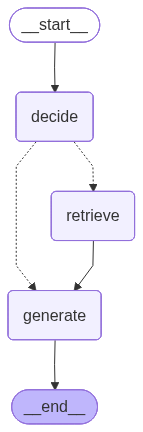

In [67]:
workflow.set_entry_point("decide")

workflow.add_conditional_edges(
    "decide",
    should_retrieve,
    {
        "retrieve" : "retrieve",
        "generate" : "generate"
    }

)

workflow.add_edge("retrieve","generate")
workflow.add_edge("generate",END)

app = workflow.compile()
app

In [68]:
def ask_question(question:str):
    initial_state = {
        "question" : question,
        "documents" : [],
        "answer" : "",
        "needs_retrieval" : False
    }
    result = app.invoke(initial_state)
    return result

In [72]:
question = "Give today's news headlines"
result = ask_question(question)
answer = result

In [73]:
print(answer['answer'])

Today's news headlines are not explicitly mentioned in the provided context. However, the context appears to be a news website or e-paper with various sections such as News, Business, Sport, Entertainment, Opinion, and more. 

Some of the topics and sections mentioned include:

- India
- World
- Movies
- Sport
- Data
- Health
- Opinion
- Science
- Business

To get the exact headlines, you would need to navigate to the specific section or topic of interest.


In [74]:
print(result)

{'question': "Give today's news headlines", 'documents': [Document(id='bd5d9a1d-b847-49f6-b7f1-b18aa3a1452f', metadata={'source': 'https://www.thehindu.com/news/', 'content_type': 'text/html; charset=UTF-8', 'title': '\n\tNews: Today’s News update from The Hindu - The Hindu\n', 'description': 'News: Get the latest news and breaking news updates on Business, Politics, Sports, Entertainment news around the world from The Hindu', 'language': 'en'}, page_content="Lead\n\t\t\t\t\t\t\t\n\n\n\n\t\t\t\t\t\t\t\tLetters\n\t\t\t\t\t\t\t\n\n\n\n\t\t\t\t\t\t\t\tOpen Page\n\t\t\t\t\t\t\t\n\n\n\n\t\t\t\t\t\t\t\tCorrections & Clarifications\n\t\t\t\t\t\t\t\n\n\n\n\n\n\n\n\n\n\nBusiness\n\n\n\n\n\n\n\n\nSECTION\n\n\n\n\n\n\t\t\t\t\t\t\t\tBusiness\n\t\t\t\t\t\t\t\n\n\n\n\t\t\t\t\t\t\t\tAgri-Business\n\t\t\t\t\t\t\t\n\n\n\n\t\t\t\t\t\t\t\tEconomy\n\t\t\t\t\t\t\t\n\n\n\n\t\t\t\t\t\t\t\tIndustry\n\t\t\t\t\t\t\t\n\n\n\n\t\t\t\t\t\t\t\tMarkets\n\t\t\t\t\t\t\t\n\n\n\n\t\t\t\t\t\t\t\tBudget\n\t\t\t\t\t\t\t\n\n